### Custom CNN model with EfficientNetB0 architecture on the RAF-DB dataset 

- Available from https://www.kaggle.com/datasets/hoanguyensgu/raf-db


In [23]:
# Imports
import os
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet, EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Scikit-learn Imports
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# Ensure single import of plotting tools
import matplotlib.pyplot as plt


In [15]:
# Paths to dataset and labels
dataset_path = '/Users/nixi/Desktop/Final-thesis-folder-24/rafdb_basic'
images_path = os.path.join(dataset_path, 'Image/aligned')  # Directory containing aligned images
labels_path = os.path.join(dataset_path, 'EmoLabel/list_patition_label.txt')  # Path to label file

# Create directories for the new dataset (train/test split)
base_output_dir = '/Users/nixi/Desktop/Final-thesis-folder-24/rafdb_basic/classifier'
train_dir = os.path.join(base_output_dir, 'train')
test_dir = os.path.join(base_output_dir, 'test')

# Create subfolders for each emotion
emotions = ['neutral', 'happy', 'sad', 'angry']
for emotion in emotions:
    os.makedirs(os.path.join(train_dir, emotion), exist_ok=True)
    os.makedirs(os.path.join(test_dir, emotion), exist_ok=True)

# Mapping of emotion labels to their corresponding categories
emotion_map = {
    4: 'happy',
    5: 'sad',
    6: 'angry',
    7: 'neutral'
}

# Read the list_patition_label.txt file and filter for emotions of interest
image_paths = []
labels = []

with open(labels_path, 'r') as f:
    lines = f.readlines()

for line in lines:
    img_name, label = line.strip().split(' ')
    label = int(label)  # Convert the label to an integer
    
    # Check if the label is in the emotion_map
    if label in emotion_map:
        # Modify image filename to account for the '_aligned' suffix
        img_name_aligned = img_name.replace(".jpg", "_aligned.jpg")
        
        # Full path to the image
        full_img_path = os.path.join(images_path, img_name_aligned)

        # Check if the image exists before adding to the list
        if os.path.exists(full_img_path):
            image_paths.append(full_img_path)
            labels.append(label)
        else:
            print(f"File not found: {full_img_path}")

# Split data into training and testing sets (80% training, 20% testing)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels)

# Copy training images into their respective folders
for img_path, label in zip(train_paths, train_labels):
    emotion = emotion_map[label]  # Get the emotion name from the label
    shutil.copy(img_path, os.path.join(train_dir, emotion, os.path.basename(img_path)))

# Copy testing images into their respective folders
for img_path, label in zip(test_paths, test_labels):
    emotion = emotion_map[label]  # Get the emotion name from the label
    shutil.copy(img_path, os.path.join(test_dir, emotion, os.path.basename(img_path)))

print("Images have been organized into training and testing sets.")


Images have been organized into training and testing sets.


/var/folders/1t/ywcqy6hd69g8pdsvmwf99pwh0000gn/T/ipykernel_22339/3599540128.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(total_counts.keys()), y=list(total_counts.values()), palette=colors)


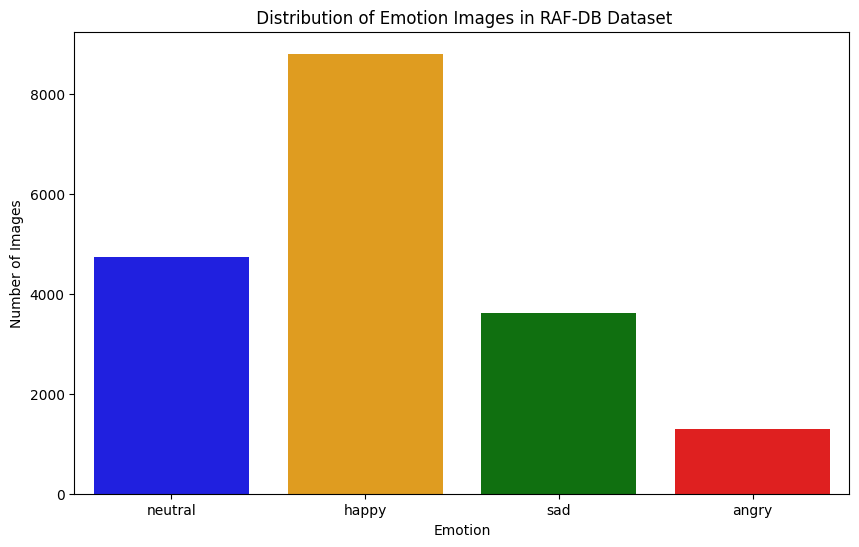

In [28]:
# visualise ratio of train and test for each emotional class ( sad, happy, angry and neutral)
import seaborn as sns

# Paths to the train and test directories
train_dir = '/Users/nixi/Desktop/Final-thesis-folder-24/rafdb_basic/classifier/train'
test_dir = '/Users/nixi/Desktop/Final-thesis-folder-24/rafdb_basic/classifier/test'

# Emotions list
emotions = ['neutral', 'happy', 'sad', 'angry']
colors = ['blue', 'orange', 'green', 'red']

# Count images in each emotion folder for training set
train_counts = {}
for emotion in emotions:
    emotion_dir = os.path.join(train_dir, emotion)
    train_counts[emotion] = len(os.listdir(emotion_dir))

# Count images in each emotion folder for testing set
test_counts = {}
for emotion in emotions:
    emotion_dir = os.path.join(test_dir, emotion)
    test_counts[emotion] = len(os.listdir(emotion_dir))

# Combine train and test counts into a single dictionary
total_counts = {}
for emotion in emotions:
    total_counts[emotion] = train_counts[emotion] + test_counts[emotion]

# Plot the data using a bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=list(total_counts.keys()), y=list(total_counts.values()), palette=colors)
plt.title(' Distribution of Emotion Images in RAF-DB Dataset')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.show()


In [8]:

# Paths to the train and test directories
train_dir = '/Users/nixi/Desktop/Final-thesis-folder-24/emotion-classifier/train'
test_dir = '/Users/nixi/Desktop/Final-thesis-folder-24/emotion-classifier/test'

# Emotions list
emotions = ['neutral', 'happy', 'sad', 'angry']

# Function to find the minimum number of images in any class
min_train_images = min([len(os.listdir(os.path.join(train_dir, emotion))) for emotion in emotions])
min_test_images = min([len(os.listdir(os.path.join(test_dir, emotion))) for emotion in emotions])

print(f"Minimum number of training images: {min_train_images}")
print(f"Minimum number of testing images: {min_test_images}")

# Equalizing the training set: reduce all classes to the size of the smallest class
for emotion in emotions:
    emotion_dir = os.path.join(train_dir, emotion)
    image_files = os.listdir(emotion_dir)
    
    # Reduce to the size of the smallest class
    if len(image_files) > min_train_images:
        selected_images = random.sample(image_files, min_train_images)
        
        # Remove extra images
        for image_file in image_files:
            if image_file not in selected_images:
                os.remove(os.path.join(emotion_dir, image_file))

# Equalizing the testing set: reduce all classes to the size of the smallest class
for emotion in emotions:
    emotion_dir = os.path.join(test_dir, emotion)
    image_files = os.listdir(emotion_dir)
    
    # Reduce to the size of the smallest class
    if len(image_files) > min_test_images:
        selected_images = random.sample(image_files, min_test_images)
        
        # Remove extra images
        for image_file in image_files:
            if image_file not in selected_images:
                os.remove(os.path.join(emotion_dir, image_file))

print(f"All categories in training and testing sets have been balanced to {min_train_images} images for training and {min_test_images} images for testing.")


Minimum number of training images: 694
Minimum number of testing images: 173
All categories in training and testing sets have been balanced to 694 images for training and 173 images for testing.


### Test out the custom CNN on RAF-DB Dataset
(Found in 3-Emotion-classifier.ipynb)

Found 12379 images belonging to 4 classes.
Found 6045 images belonging to 4 classes.
Training with frozen EfficientNetB0 base model...
Epoch 1/100


/Users/nixi/Desktop/Final-thesis-folder-24/.conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


386/386 ━━━━━━━━━━━━━━━━━━━━ 57s 124ms/step - accuracy: 0.2700 - loss: 2.0491 - val_accuracy: 0.1938 - val_loss: 1.7176 - learning_rate: 1.0000e-04
Epoch 2/100
  1/386 ━━━━━━━━━━━━━━━━━━━━ 37s 97ms/step - accuracy: 0.2188 - loss: 1.8908

/Users/nixi/Desktop/Final-thesis-folder-24/.conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.2188 - loss: 1.8908 - val_accuracy: 0.1724 - val_loss: 1.7705 - learning_rate: 1.0000e-04
Epoch 3/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 47s 121ms/step - accuracy: 0.2411 - loss: 1.9130 - val_accuracy: 0.1930 - val_loss: 1.7129 - learning_rate: 1.0000e-04
Epoch 4/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.2500 - loss: 1.7919 - val_accuracy: 0.3448 - val_loss: 1.6292 - learning_rate: 1.0000e-04
Epoch 5/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 48s 123ms/step - accuracy: 0.2447 - loss: 1.8341 - val_accuracy: 0.1933 - val_loss: 1.7285 - learning_rate: 1.0000e-04
Epoch 6/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - accuracy: 0.2500 - loss: 1.4375 - val_accuracy: 0.2759 - val_loss: 1.6953 - learning_rate: 1.0000e-04
Epoch 7/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.2490 - loss: 1.8005 - val_accuracy: 0.1937 - val_loss: 1.6898 - learning_rate: 1.0000e-04
Epoch 8/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step 

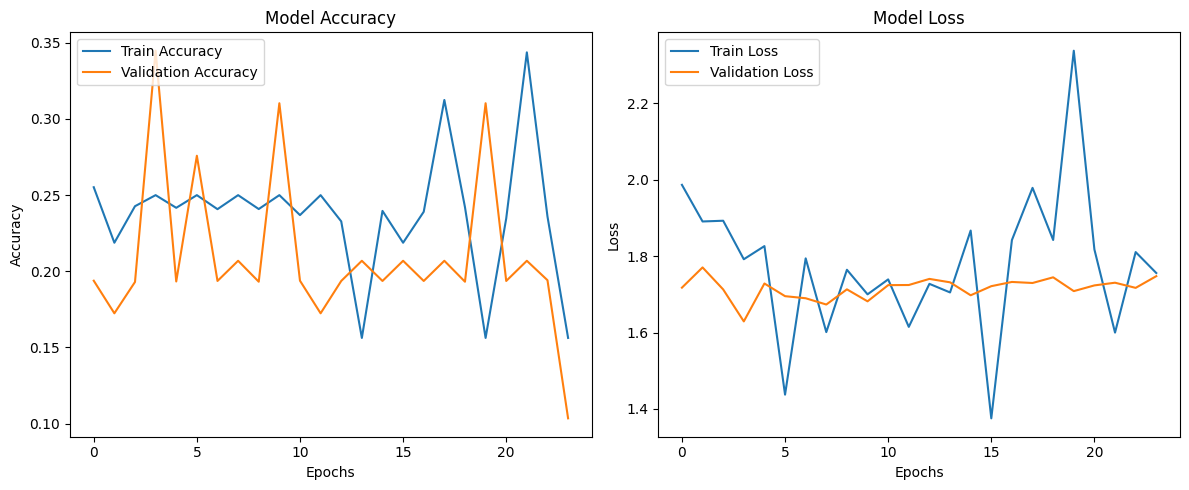

In [25]:
#Paths to the train and test directories
train_dir = '/Users/nixi/Desktop/Final-thesis-folder-24/rafdb_basic/classifier/train'
test_dir = '/Users/nixi/Desktop/Final-thesis-folder-24/rafdb_basic/classifier/test'

# Data Augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=30,  
    width_shift_range=0.2,
    height_shift_range=0.3,
    horizontal_flip=True,
    zoom_range=0.2,  
    shear_range=0.2,  
    fill_mode='nearest',
    rescale=1.0/255.0
)

# Load training and validation data
train_generator = data_augmentation.flow_from_directory(
    train_dir,
    target_size=(100, 100),  # Adjusted to 100x100, the datasets image size
    batch_size=32,
    class_mode='categorical'
)

test_generator = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(
    test_dir,
    target_size=(100, 100),  # Adjusted to 100x100
    batch_size=32,
    class_mode='categorical'
)

# Get class labels from the generator
train_labels = train_generator.classes
classes = list(train_generator.class_indices.keys())

# Fix class weights to address potential imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels)

class_weights_dict = {0: 2.0, 1: 0.4, 2: 0.8, 3: 2.0} # adjusted weights for each corresponding class
#dict(enumerate(class_weights))

# Create the MobileNet model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
base_model.trainable = False  # Freeze the base model


# Define the model
model = Sequential([
    base_model,  # EfficientNetB0 layers
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),  # to prevent overfitting
    
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    Flatten(),
    Dense(512, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')])


# Compile the model
initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("model_weights.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

callbacks_list = [
    ModelCheckpoint("model_weights.keras", monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)]


# Train the model with frozen base
print("Training with frozen EfficientNetB0 base model...")
history_frozen = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=100,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    callbacks=callbacks_list,
    class_weight=class_weights_dict)



# Unfreeze the top layers of the base model for fine-tuning
print("Fine-tuning the model...")
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Freeze all but the last 4 layers
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with unfrozen layers
history_unfrozen = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    callbacks=callbacks_list,
    class_weight=class_weights_dict)

print("Training complete.")

history = {}
for k in history_frozen.history.keys():
    history[k] = history_frozen.history[k] + history_unfrozen.history[k]

# Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy 
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss 
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [1]:
# Save the model
model.save("model_RAF-DB.keras")  

NameError: name 'model' is not defined

### Model Metrics
-  Plotting training & validation accuracy for the frozen base model

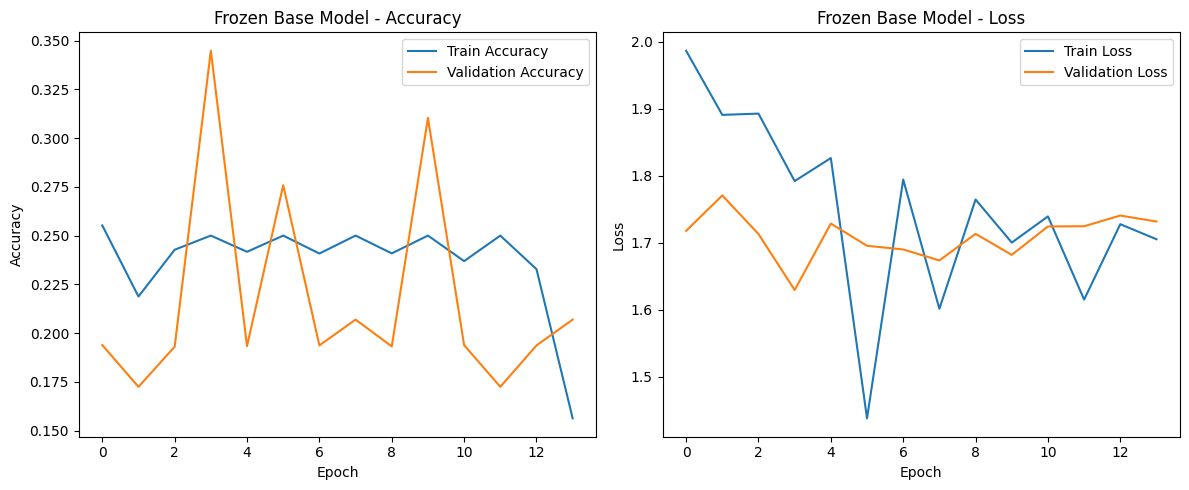

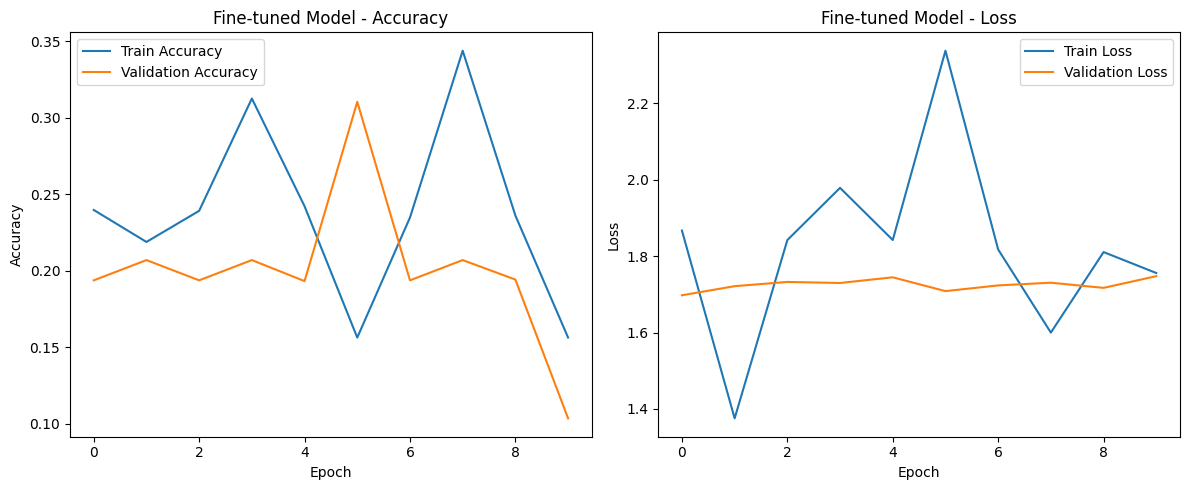

In [29]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_frozen.history['accuracy'], label='Train Accuracy')
plt.plot(history_frozen.history['val_accuracy'], label='Validation Accuracy')
plt.title('Frozen Base Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_frozen.history['loss'], label='Train Loss')
plt.plot(history_frozen.history['val_loss'], label='Validation Loss')
plt.title('Frozen Base Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training & validation accuracy for fine-tuned model
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_unfrozen.history['accuracy'], label='Train Accuracy')
plt.plot(history_unfrozen.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-tuned Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_unfrozen.history['loss'], label='Train Loss')
plt.plot(history_unfrozen.history['val_loss'], label='Validation Loss')
plt.title('Fine-tuned Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step


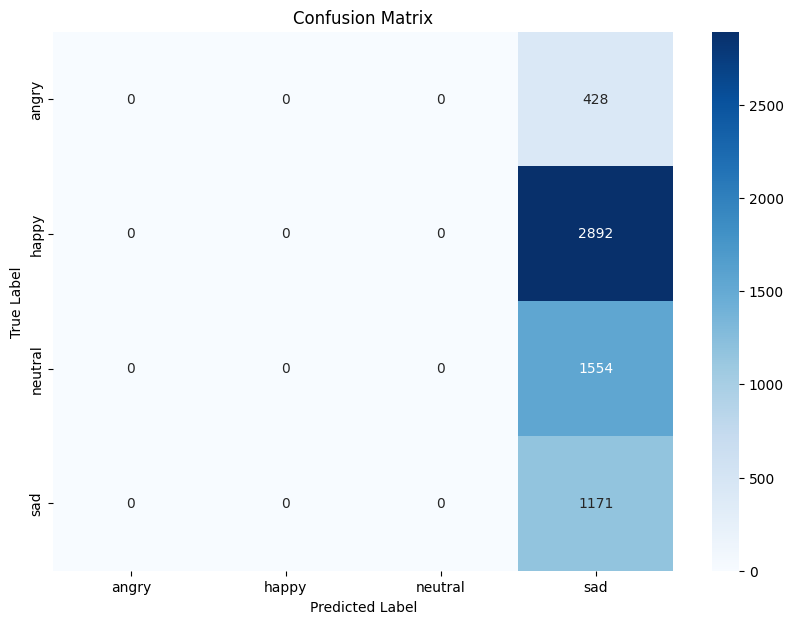

In [30]:
# Confusion matrix
test_labels = test_generator.classes

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Step 2: Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

HoangUyenSGU (2024). RAF-DB. Kaggle.com. Available at: https://www.kaggle.com/datasets/hoanguyensgu/raf-db [Accessed 1 June 2024].

‌